# Experiment Tracking with PyTorch
This notebook demonstrates how to track experiments in PyTorch using TensorBoard. Two models were trained to classify food images:

- Training a model from scratch (TinyVGG).
- Using transfer learning with a pre-trained model (EfficientNet_B0).

## Project Imports

In [ ]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('2.3.0+cu121', '0.18.0+cu121')

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import modules made for code reuse
try:
    from modules import data_setup, engine
except:
    # Get the scripts
    print("[INFO] Couldn't find modules scripts... downloading them from GitHub.")
    !git clone https://github.com/mlgomez0/deep_learning_projects
    !mv deep_learning_projects/modules .
    !rm -rf deep_learning_projects
    from modules import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find modules scripts... downloading them from GitHub.
Cloning into 'deep_learning_projects'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 24 (delta 7), reused 17 (delta 3), pack-reused 0
Receiving objects: 100% (24/24), 15.01 MiB | 6.73 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
from modules.engine import train # Visit https://github.com/mlgomez0/deep_learning_projects/blob/main/modules/engine.py to review the code for training the models

## Device Agnostic Code and function for manual_seed

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # setting up device agnostic code

In [ ]:
def set_seed(seed:int=42):
  """Sets random sets for torch operations.

  Args:
    seed (int, optional): The desired seed value. Defaults to 42.
  """
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

## Downloading the data

In [ ]:
import os
from pathlib import Path
import zipfile
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True):
  """Downloads a file from a url and then extracts it locally.
  """
  print(f"[INFO] Downloading {source}...")

  data_path = Path("data/")
  image_path = data_path / destination

  if image_path.is_dir():
    print("Dir is already created")
  else:
    image_path.mkdir(parents=True, exist_ok=True)
    target_file = Path(source).name
    with open(data_path / target_file, 'wb') as f:
      request = requests.get(source)
      print(f"[FILE] Downloading {target_file} from source")
      f.write(request.content)
    with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
      zip_ref.extractall(image_path)
    if remove_source:
      os.remove(data_path / target_file)

  return image_path


In [ ]:
image_path = download_data(
    source="https://github.com/mlgomez0/deep_learning_projects/raw/main/datasets/pizza_steak_sushi.zip", # Dowloading samples data
    destination="pizza_steak_sushi"
)

[INFO] Downloading https://github.com/mlgomez0/deep_learning_projects/raw/main/datasets/pizza_steak_sushi.zip...
[FILE] Downloading pizza_steak_sushi.zip from source


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Customizing writers for Tensorboard

In [ ]:
from datetime import datetime

def create_writer(experiment_name:str,
                  model_name:str,
                  extra:str=None):

  timestamp = datetime.now().strftime("%y-%m-%d")
  if extra:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

  return SummaryWriter(log_dir=log_dir)

## TinyVGG

### Transforming data to be used in TinyVGG

In [ ]:
tiny_vgg_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_dataloader_tiny_vgg, test_dataloader_tiny_vgg, class_names = data_setup.create_dataloaders(
  train_dir=train_dir,
  test_dir=test_dir,
  transform=tiny_vgg_transform,
  batch_size=32
)

### TinyVGG model

In [ ]:
# Implementation of TinyVGG model architecture https://poloclub.github.io/cnn-explainer/
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1

        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
        )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units * 16 * 16,
            out_features=output_shape
        )
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
model_0 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### Training TinyVGG

In [ ]:
writer_tiny_vgg = create_writer(
    experiment_name='tiny_vgg_model',
    model_name="model_0",
    extra="10_epochs"
) # this writer will allow us to log data for later visualization using tensorboard
writer_tiny_vgg

In [ ]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

In [ ]:
#from modules.engine import train

set_seed()
example_input = torch.randn(32, 3, 64, 64).to(device)

results = train(
    model=model_0,
    train_dataloader=train_dataloader_tiny_vgg,
    test_dataloader=test_dataloader_tiny_vgg,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=30,
    device=device,
    writer=writer_tiny_vgg,
    example_input=example_input
)


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1 | train_loss: 1.1893 | train_acc: 0.2969 | test_loss: 1.2745 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.2129 | train_acc: 0.2695 | test_loss: 1.1101 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0994 | train_acc: 0.3047 | test_loss: 1.1132 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0931 | train_acc: 0.4258 | test_loss: 1.1190 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0963 | train_acc: 0.3047 | test_loss: 1.1246 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0921 | train_acc: 0.4258 | test_loss: 1.1302 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.0909 | train_acc: 0.4258 | test_loss: 1.1346 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.0884 | train_acc: 0.4258 | test_loss: 1.1372 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.0992 | train_acc: 0.3047 | test_loss: 1.1391 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.0874 | train_acc: 0.4258 | test_loss: 1.1417 | test_acc: 0.2604
Epoch: 11 | train_loss: 1.1174 | train_acc: 0.3047 | test_loss: 1.1416 | test_acc: 0.2604
Epoch: 12 | train_l

## EfficientNet_B0: Transfer Learning

### Transforming the data to be used with EfficientNet_B0 model

In [ ]:
# Creating a transformer to tranform the data to be used in EfficientNet_B0 model

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform_EffNetB0 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
  train_dir=train_dir,
  test_dir=test_dir,
  transform=transform_EffNetB0,
  batch_size=32
)

### Downloading model

In [ ]:
# Dowloading EfficientNet_B0 from torchvision
# https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Best available
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s]


In [ ]:
model.classifier # This section will be retrained using new data

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
for param in model.features.parameters(): # This piece of code freeze the model parameters so they don't get retrained
  param.requires_grad = False

In [ ]:
set_seed()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device) # Here we redefine the classifier of the model moving from 1000 classes to only 3 classes (classes in our dummy dataset)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Note: It can be seen above that the only trainable parameters are in the classifier of the model. The other parameters are not trainable because we froze them in previous block of code.

### Training EfficientNet_B0

In [ ]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
example_input = torch.randn(32, 3, 224, 224).to(device)

writer_effnetb0 = create_writer(
    experiment_name='effnetb0_transfer_Learning',
    model_name="effnetb0",
    extra="10_epochs"
) # this writer will allow us to log data for later visualization using tensorboard
writer_effnetb0

In [ ]:
set_seed()

results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=30,
    device=device,
    writer=writer_effnetb0,
    example_input=example_input
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8530 | train_acc: 0.6289 | test_loss: 0.4218 | test_acc: 0.8561
Epoch: 2 | train_loss: 0.6486 | train_acc: 0.6914 | test_loss: 0.3168 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.2929 | train_acc: 0.8984 | test_loss: 0.2883 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.3614 | train_acc: 0.8359 | test_loss: 0.2521 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.5230 | train_acc: 0.7773 | test_loss: 0.3812 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.7808 | train_acc: 0.8242 | test_loss: 0.3218 | test_acc: 0.8447
Epoch: 7 | train_loss: 0.1350 | train_acc: 0.9648 | test_loss: 0.3047 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.6783 | train_acc: 0.7852 | test_loss: 0.3143 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.7029 | train_acc: 0.8281 | test_loss: 0.3401 | test_acc: 0.8551
Epoch: 10 | train_loss: 0.8676 | train_acc: 0.7617 | test_loss: 0.2905 | test_acc: 0.8759
Epoch: 11 | train_loss: 0.2183 | train_acc: 0.9336 | test_loss: 0.6810 | test_acc: 0.7746
Epoch: 12 | train_l

In [ ]:
results

{'train_loss': [0.8530440926551819,
  0.6485530640929937,
  0.2928703613579273,
  0.36142015270888805,
  0.5229970254004002,
  0.7807909734547138,
  0.13504156842827797,
  0.6782997893169522,
  0.7028559655882418,
  0.8675501858815551,
  0.21828204812482,
  0.6163798240013421,
  0.8190612667240202,
  0.11188953812234104,
  0.19678922556340694,
  0.19430125481449068,
  0.050814414978958666,
  0.09185625449754298,
  0.08048972161486745,
  0.502085896441713,
  0.791793504729867,
  0.8395453013945371,
  0.2737628670874983,
  0.5608353074640036,
  0.48855124111287296,
  0.8228526320308447,
  0.7903845665277913,
  0.1287016092101112,
  0.2756599234417081,
  0.20556397413020022],
 'train_acc': [0.62890625,
  0.69140625,
  0.8984375,
  0.8359375,
  0.77734375,
  0.82421875,
  0.96484375,
  0.78515625,
  0.828125,
  0.76171875,
  0.93359375,
  0.79296875,
  0.765625,
  0.96484375,
  0.921875,
  0.95703125,
  0.9921875,
  0.9765625,
  0.9765625,
  0.86328125,
  0.80859375,
  0.83203125,
  0.8398

## Experiments tracking with Tensorboard

Note: The writers helped us to stored in a folder called runs, this folder will be use by tensorboard

In [ ]:
# This code should be uncommented to run in a notebook
# %load_ext tensorboard
# %tensorboard --logdir runs

The Tensorboard looks as below:

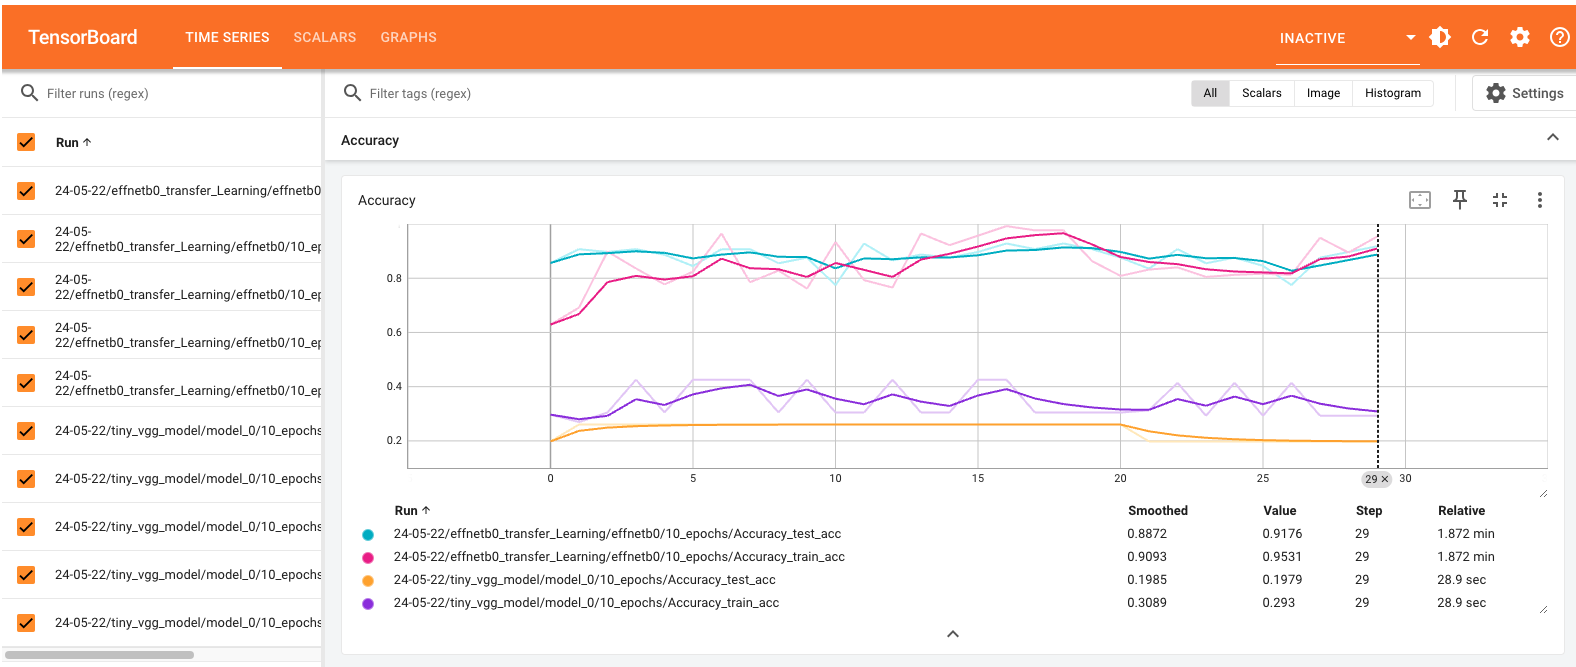